# Jet selection

**Goal:** How does the jet selection accuracy c.f. b/w pairAGraph and the baseline analysis selection?

I really should be considering 3 categories rn:
1. 4b
2. 3b+1loose
3. 3b

And for now I'll just be considering the *nominal* signal selection.


In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import json
from itertools import product

import matplotlib.pyplot as plt
from matplotlib import gridspec
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  
from sklearn.preprocessing import StandardScaler

import os
os.sys.path.append('../code')
from plotting import SR_x, SR_y1, SR_y2
from plotting import CR_x, CR_y1, CR_y2
from plotting import SB_x, SB_y1, SB_y2
from eventDisplays import rainbow_text, truthDisplay

from preprocess import process4bs

%load_ext autoreload
%autoreload 2

Running w/ conda env: don't import root packages.


Let's factorize this, so at first just look at the `_even` file (which means training on even event numbers, and test on odd event numbers).

In [42]:
in_dir = '../data/SMNR_mc16a_PFlow-APR2020-5jets/'
df = pd.concat([pd.read_hdf(f'{in_dir}/df_SM_2b_{split}_3b.h5') for split in ['even','odd']])

In [3]:
for c in df.columns:
    print(c)

eventNumber
nresolvedJets
resolved_nBTags
mcEventWeight
weight_pileup
rand_run_nr
j0_pt
j0_eta
j0_phi
j0_E
j0_Db
j0_sf
j1_pt
j1_eta
j1_phi
j1_E
j1_Db
j1_sf
j2_pt
j2_eta
j2_phi
j2_E
j2_Db
j2_sf
j3_pt
j3_eta
j3_phi
j3_E
j3_Db
j3_sf
j4_pt
j4_eta
j4_phi
j4_E
j4_Db
j4_sf
njets
trigger
mc_sf
ntag
truth_mhh
truth_pthh
h0_pt
h0_eta
h0_phi
h0_barcode
h1_pt
h1_eta
h1_phi
h1_barcode
b0_pt
b0_eta
b0_phi
b0_parent_barcode
b1_pt
b1_eta
b1_phi
b1_parent_barcode
b2_pt
b2_eta
b2_phi
b2_parent_barcode
b3_pt
b3_eta
b3_phi
b3_parent_barcode
b0_jidx
b0_drMatch
b1_jidx
b1_drMatch
b2_jidx
b2_drMatch
b3_jidx
b3_drMatch
j0_bidx
j1_bidx
j2_bidx
j3_bidx
j4_bidx
j0_drMatch
j1_drMatch
j2_drMatch
j3_drMatch
j4_drMatch
correctPair
sameParent
unique
dRmatch
goodJets
ml_j0_pt
ml_j1_pt
ml_j2_pt
ml_j3_pt
ml_j4_pt
ml_j0_eta
ml_j1_eta
ml_j2_eta
ml_j3_eta
ml_j4_eta
ml_j0_phi
ml_j1_phi
ml_j2_phi
ml_j3_phi
ml_j4_phi
ml_j0_E
ml_j1_E
ml_j2_E
ml_j3_E
ml_j4_E
ml_j0_Db
ml_j1_Db
ml_j2_Db
ml_j3_Db
ml_j4_Db
max_prob
predPair
idx_HCa

**Step 1:** Calculate the accuracy of selecting the right jets w/ pairAGraph

This is just stored in the `goodJets` variable.


In [9]:
np.sum(df.loc[df.goodJets,'mc_sf']),np.sum(df.loc[df.correctPair!=-1,'mc_sf'])

(30.374427302412645, 30.374427302412645)

In [10]:
cols = [f'idx_HC{i}_j{j}' for i in range(2) for j in range(2)]
cols+= [f'j{i}_bidx' for i in range(5)]
cols+= [f'b{i}_jidx' for i in range(4)]

df[cols].head()

idx_HC0_j0  idx_HC0_j1  idx_HC1_j0  idx_HC1_j1  j0_bidx  j1_bidx  \
entry                                                                     
3               0           2           1           3        0        1   
7               1           2           0           3        0        1   
9               0           3           1           2        0        1   
13              0           4           3           2        0        3   
19              0           1           2           3        1        2   

       j2_bidx  j3_bidx  j4_bidx  b0_jidx  b1_jidx  b2_jidx  b3_jidx  
entry                                                                 
3            3        2       -1        0        1        3        2  
7            2        3       -1        0        1        2        3  
9            2        3       -1        0        1        2        3  
13          -1        1        2        0        3        4        1  
19           0        3       -1        2        0        1        3

In [11]:
hc_idx = df[[f'idx_HC{i}_j{j}' for i in range(2) for j in range(2)]].values
b_idx  =  df[[f'b{i}_jidx' for i in range(4)]].values

To get these on the same footing, just need to sort the arrays

In [43]:
correctJets = np.sum(np.sort(hc_idx,axis=1) == np.sort(b_idx,axis=1),axis=1)==4

In [13]:
np.sum(df.loc[correctJets,'mc_sf']),np.sum(df.loc[df.correctPair!=-1,'mc_sf'])

(37.68959115044461, 30.374427302412645)

In [14]:
df.loc[correctJets & ~df.goodJets,cols+[f'b{i}_drMatch' for i in range(4)]]

idx_HC0_j0  idx_HC0_j1  idx_HC1_j0  idx_HC1_j1  j0_bidx  j1_bidx  \
entry                                                                      
3                0           2           1           3        0        1   
69               0           3           2           1        0        2   
149              0           4           2           3        0       -1   
191              0           2           1           3        0        1   
213              1           2           0           4        0        1   
...            ...         ...         ...         ...      ...      ...   
686546           1           2           0           3        1        3   
686582           0           2           1           3        3        1   
686620           0           2           1           3        0        1   
686628           0           3           4           2        0       -1   
686676           0           2           1           3        0        1   

        j2_bidx  j3_bidx  j4_bidx  b0_jidx  b1_jidx  b2_jidx  b3_jidx  \
entry                                                                   
3             3        2       -1        0        1        3        2   
69            1        3       -1        0        2        1        3   
149           1        2        3        0        2        3        4   
191           3        2       -1        0        1        3        2   
213           2       -1        3        0        1        2        4   
...         ...      ...      ...      ...      ...      ...      ...   
686546        0        2       -1        2        0        3        1   
686582        0        2       -1        2        1        3        0   
686620        2        3       -1        0        1        2        3   
686628        2        3        1        0        4        2        3   
686676        3        2       -1        0        1        3        2   

        b0_drMatch  b1_drMatch  b2_drMatch  b3_drMatch  
entry                                                   
3         0.051460    0.165292    0.079048    0.311243  
69        0.023365    0.021847    0.022416    0.329167  
149       0.011088    0.180101    0.046679    1.143087  
191       0.047008    0.015435    0.019929    0.708235  
213       0.048690    0.020570    0.020300    0.534895  
...            ...         ...         ...         ...  
686546    0.073194    0.005092    0.095419    1.269862  
686582    0.016542    0.018273    0.018647    1.624900  
686620    0.014033    0.085955    0.027597    1.073847  
686628    0.004646    0.016276    0.009647    0.600714  
686676    0.011012    0.015107    0.012316    1.676110  

[31965 rows x 17 columns]

So sometimes `correctJets` can be a looser criterion, but it looks like this is mostly b/c of the $R_{match} < 0.3$ criterion.

In [15]:
np.sum(df.loc[correctJets&(df.correctPair!=-1),'mc_sf']) / np.sum(df.loc[df.correctPair!=-1,'mc_sf'])

0.9494177626426202

**Step 2:** Calculate the accuracy of selecting the right jets w/ the baseline

In [16]:
Dbs = df[[f'ml_j{i}_Db' for i in range(5)]].values

#pts = df[[f'j{i}_pt' for i in range(5)]].values

In [12]:
Dbs[Dbs>=0]

array([2., 0., 2., ..., 2., 2., 0.])

In [17]:
nEvts = len(df)

In [14]:
Dbs[(Dbs>=0) & ((df.ntag==3) & (df.njets==5)).values.reshape(-1,1)] #.reshape()

array([2., 0., 2., ..., 2., 2., 0.])

Hmmmmm - I'm *not* exactly sure why this isn't an even number (divisible by 4)

In [15]:
Dbs[(df.ntag==4)&(df.njets==4)]

array([[2., 2., 2., 2., 0.],
       [2., 2., 2., 2., 0.],
       [1., 2., 0., 2., 0.],
       ...,
       [2., 2., 2., 2., 0.],
       [2., 2., 2., 2., 0.],
       [0., 2., 2., 2., 0.]])

In [18]:
def revOrder(x):
    '''
    rev the order of the arg sort
    '''
    
    x_rev = x.copy()
    
    x_rev[x==0] = 4
    x_rev[x==1] = 3
    x_rev[x==3] = 1
    x_rev[x==4] = 0
    
    return x_rev

In [19]:
baseline_idx = np.zeros((len(df),4))

# for 4-jets no work necessary
baseline_idx[df.njets==4] = np.array([0,1,2,3])

# 5 jets w/ 5 b-tags, also easy, choose the four leading
baseline_idx[df.ntag==5] = np.array([0,1,2,3])

# 5 jets w/ 4 bs
mask = (df.ntag==4) & (df.njets==5)
baseline_idx[mask] = np.argsort(Dbs[mask]>=0)[:,1:]

# for 3b w/ 5 jets, there's a little bit of code gymnastics going on 
mask = (df.ntag==3) & (df.njets==5)
baseline_idx[mask] = revOrder(np.argsort(Dbs[mask,::-1],axis=1)[:,::-1])[:,:4]

In [20]:
baseline_sorted = np.sort(baseline_idx,axis=1)
baseline_sorted

array([[0., 1., 2., 3.],
       [0., 1., 2., 3.],
       [0., 1., 2., 3.],
       ...,
       [0., 1., 2., 3.],
       [0., 1., 2., 3.],
       [0., 1., 2., 3.]])

In [21]:
baselineCorrect = np.sum(np.sort(baseline_idx,axis=1) == np.sort(b_idx,axis=1),axis=1)==4

In [73]:
baselineCorrect

array([ True,  True,  True, ..., False,  True,  True])

In [22]:
np.sum(df.loc[baselineCorrect&(df.correctPair!=-1),'mc_sf']) / np.sum(df.loc[df.correctPair!=-1,'mc_sf'])

0.9155334357168369

Well - right off the bat, this is pretty encouraging that pairAGraph is getting more of the jets *correct* for signal!!

**Need to divide this down into the 4b, 3b+1 loose, and 3b, categoreis**

In [23]:
nLoose = np.sum(Dbs==-1,axis=1)

In [24]:
nLoose[(df.ntag==3)&(df.correctPair!=-1)]

array([0, 1, 1, ..., 0, 0, 0])

In [25]:
for m, label in zip([df.ntag>=4, (df.ntag==3) & (nLoose>0), (df.ntag==3) & (nLoose==0)],
                    ['4b','3b + 1 loose','3b']):
    
    mask =  m & (df.correctPair!=-1)
    den = np.sum(df.loc[mask,'mc_sf'])
    
    pag_acc  = np.sum(df.loc[correctJets    &mask,'mc_sf']) / den
    base_acc = np.sum(df.loc[baselineCorrect&mask,'mc_sf']) / den
    
    print(f'{label} correct jets: ')
    print(f'  pairAGraph: {100*pag_acc:.1f}%, baseline: {100*base_acc:.1f}%\n')

4b correct jets: 
  pairAGraph: 96.7%, baseline: 96.0%

3b + 1 loose correct jets: 
  pairAGraph: 96.3%, baseline: 95.2%

3b correct jets: 
  pairAGraph: 91.6%, baseline: 83.2%



But - this is *absolutely awesome* that pairAGraph *is* doing better than the baseline on selecting the correct jets :-)

*Let's also check (for 4b) these numbers w/r.t. all of the signal events, and with the preprocessing I've already done on the df, I can just get this w/r.t. the 2016 triggers.*

In [76]:
np.sum(baselineCorrect[df.correctPair!=-1]),np.sum(baselineCorrect[df.goodJets])

(104710, 104710)

In [77]:
np.sum(correctJets[df.correctPair!=-1]),np.sum(correctJets[df.goodJets])

(108761, 108761)

In [79]:
mask = (df.ntag>=4) & df.trigger

print('How often do we select the correct jets? (w/r.t. mc_sf)')
num_pag = np.sum(df.loc[correctJets & df.goodJets & mask,'mc_sf'])
num_base= np.sum(df.loc[baselineCorrect & df.goodJets & mask,'mc_sf'])
den = np.sum(df.loc[mask,'mc_sf'])
eff_pag = 100 *  num_pag / den
eff_base= 100 *  num_base/ den
print(f'  4b w/ 2016 triggers: num_pag = {num_pag:.2f}, num_base = {num_base:.2f}, den = {den:.2f}')
print(f'  4b w/ 2016 triggers: pairAGraph = {eff_pag:.2f}%, baseline = {eff_base:.2f}%')


print('How often do we select the correct jets? (w/r.t. mcEventWeight * weight_pileup)')
num_pag = np.sum(df.loc[correctJets & df.goodJets & mask,'mcEventWeight'] * df.loc[correctJets & mask,'weight_pileup'])
num_base= np.sum(df.loc[baselineCorrect & df.goodJets & mask,'mcEventWeight']*df.loc[baselineCorrect & mask,'weight_pileup'])
den = np.sum(df.loc[mask,'mcEventWeight'] * df.loc[mask,'weight_pileup'])
eff_pag = 100 *  num_pag / den
eff_base= 100 *  num_base/ den
print(f'  4b w/ 2016 triggers: num_pag = {num_pag:.2f}, num_base = {num_base:.2f}, den = {den:.2f}')
print(f'  4b w/ 2016 triggers: pairAGraph = {eff_pag:.2f}%, baseline = {eff_base:.2f}%')


print('How often do we select the correct jets? (w/r.t. mcEventWeight)')
num_pag = np.sum(df.loc[correctJets & df.goodJets & mask,'mcEventWeight'])
den = np.sum(df.loc[mask,'mcEventWeight'])
num_base= np.sum(df.loc[baselineCorrect & df.goodJets & mask,'mcEventWeight'])
eff_pag = 100 *  num_pag / den
eff_base= 100 *  num_base/ den
print(f'  4b w/ 2016 triggers: num_pag = {num_pag:.2f}, num_base = {num_base:.2f}, den = {den:.2f}')
print(f'  4b w/ 2016 triggers: pairAGraph = {eff_pag:.2f}%, baseline = {eff_base:.2f}%')

print('How often do we select the correct jets? (unweighted)')
num_pag = np.sum(correctJets & df.goodJets & mask)
den = np.sum(mask)
num_base= np.sum(baselineCorrect & df.goodJets & mask)
eff_pag = 100 *  num_pag / den
eff_base= 100 *  num_base/ den
print(f'  4b w/ 2016 triggers: num_pag = {num_pag:.2f}, num_base = {num_base:.2f}, den = {den:.2f}')
print(f'  4b w/ 2016 triggers: pairAGraph = {eff_pag:.2f}%, baseline = {eff_base:.2f}%')


How often do we select the correct jets? (w/r.t. mc_sf)
  4b w/ 2016 triggers: num_pag = 14.48, num_base = 14.38, den = 17.84
  4b w/ 2016 triggers: pairAGraph = 81.18%, baseline = 80.59%
How often do we select the correct jets? (w/r.t. mcEventWeight * weight_pileup)
  4b w/ 2016 triggers: num_pag = 1401.59, num_base = 1391.26, den = 1725.37
  4b w/ 2016 triggers: pairAGraph = 81.23%, baseline = 80.64%
How often do we select the correct jets? (w/r.t. mcEventWeight)
  4b w/ 2016 triggers: num_pag = 1401.17, num_base = 1390.75, den = 1725.58
  4b w/ 2016 triggers: pairAGraph = 81.20%, baseline = 80.60%
How often do we select the correct jets? (unweighted)
  4b w/ 2016 triggers: num_pag = 52791.00, num_base = 52377.00, den = 64655.00
  4b w/ 2016 triggers: pairAGraph = 81.65%, baseline = 81.01%


**Step 3:** Look at the jet selection efficiency as a function of $m_{hh}$

In [81]:
mhh_edg = np.linspace(250,1250,26)
xx = 0.5*(mhh_edg[1:]+mhh_edg[:-1])

# np.array([150, 250, 262, 275, 288, 302, 317, 332, 348, 365, 383, 
#                     402, 422, 443, 465, 488, 512, 537, 563, 591, 620, 651, 
#                     683, 717, 752, 789, 828, 869, 912, 957,1004, 1054, 1106, 
#                     1161, 1219, 1279, 1342, 1409, 1479, 1552, 1629, 1710, 
#                     1795, 1884, 1978, 2076])

In [82]:
text = "$\mathbf{ATLAS}$ Simulation Internal\n"
text += f"SM NR mc16a APR20 MNT prod\n"
text += "2016 triggers, DL1r 77% WP, 4 good jets"

In [83]:
figDir = 'figures/SMNR_mc16a_PFlow-APR2020-5jets/SM_2b'

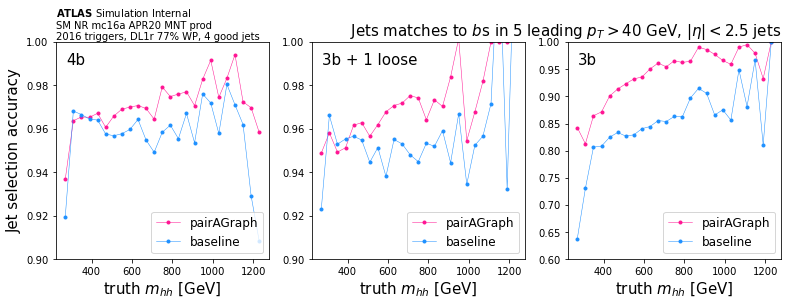

In [28]:
fig, axes = plt.subplots(1,3,figsize=(13,4))

for m, ax,label in zip([df.ntag>=4, (df.ntag==3) & (nLoose>0), (df.ntag==3) & (nLoose==0)],
                       axes, ['4b','3b + 1 loose','3b']):
    
    mask =  m & (df.correctPair!=-1)
    den,_ = np.histogram(df.loc[mask,'truth_mhh'],mhh_edg,weights=df.loc[mask,'mc_sf'])

    for mi, l,color in zip([correctJets,baselineCorrect],['pairAGraph','baseline'],['deeppink','dodgerblue']):
        
        num,_  = np.histogram(df.loc[mask & mi,'truth_mhh'], mhh_edg, weights=df.loc[mask & mi,'mc_sf'])
        sqd,_  = np.histogram(df.loc[mask & mi,'truth_mhh'], mhh_edg, weights=df.loc[mask & mi,'mc_sf']**2)
        
        ax.plot(xx, num/den, color=color,label=l, marker='.',linewidth=0.5)
        
    ax.set_xlabel('truth $m_{hh}$ [GeV]',fontsize=15)
    if label == '4b':
        ax.set_ylabel('Jet selection accuracy',fontsize=15)
        ax.text(0,1,text,ha='left',va='bottom',transform=ax.transAxes)  
    elif label=='3b':
        ax.set_title('Jets matches to $b$s in 5 leading $p_T > 40$ GeV, $|\eta|<2.5$ jets',
                     loc='right',fontsize=15)
    
    ax.text(0.05,0.95,label,ha='left',va='top',fontsize=15,transform=ax.transAxes)
    ax.legend(loc='lower right',fontsize=12)
        
    if label == '3b':
        ax.set_ylim(.6,1)
    else:
        ax.set_ylim(.9,1)
     
    plt.savefig(f'{figDir}/jetSelAcc_truth_mhh_correctJetsExist.pdf',bbox_inches='tight')

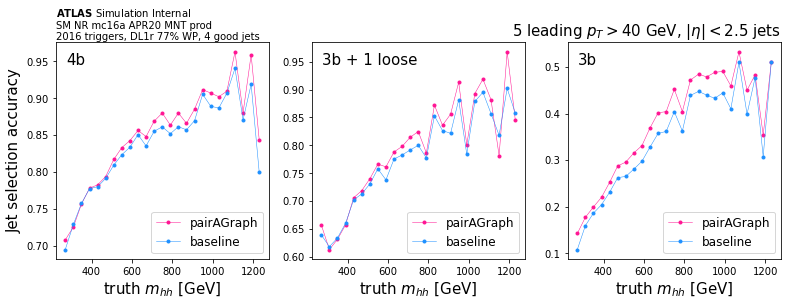

In [85]:
fig, axes = plt.subplots(1,3,figsize=(13,4))

for mask, ax,label in zip([df.ntag>=4, (df.ntag==3) & (nLoose>0), (df.ntag==3) & (nLoose==0)],
                           axes, ['4b','3b + 1 loose','3b']):
    
    #mask =  m & (df.correctPair!=-1)
    den,_ = np.histogram(df.loc[mask,'truth_mhh'],mhh_edg,weights=df.loc[mask,'mc_sf'])

    for mi, l,color in zip([correctJets,baselineCorrect],['pairAGraph','baseline'],['deeppink','dodgerblue']):
        
        num,_  = np.histogram(df.loc[mask & mi & df.goodJets,'truth_mhh'],mhh_edg,
                              weights=df.loc[mask & mi & df.goodJets,'mc_sf'])
        
        sqd,_  = np.histogram(df.loc[mask & mi & df.goodJets,'truth_mhh'],mhh_edg,
                              weights=df.loc[mask & mi & df.goodJets,'mc_sf']**2)
        
        ax.plot(xx, num/den, color=color,label=l, marker='.',linewidth=0.5)
        
    ax.set_xlabel('truth $m_{hh}$ [GeV]',fontsize=15)
    if label == '4b':
        ax.set_ylabel('Jet selection accuracy',fontsize=15)
        ax.text(0,1,text,ha='left',va='bottom',transform=ax.transAxes)  
    elif label=='3b':
        ax.set_title('5 leading $p_T > 40$ GeV, $|\eta|<2.5$ jets',
                     loc='right',fontsize=15)
    
    ax.text(0.05,0.95,label,ha='left',va='top',fontsize=15,transform=ax.transAxes)
    ax.legend(loc='lower right',fontsize=12)
        
    plt.savefig(f'{figDir}/jetSelAcc_truth_mhh_allJets.pdf',bbox_inches='tight')

In [30]:
df.head()

eventNumber  nresolvedJets  resolved_nBTags  mcEventWeight  \
entry                                                               
3           286535              5                3       0.031172   
7           285372              5                3       0.031172   
9           286648              5                3       0.031172   
13          285862              6                3      -0.031172   
19          285097              4                3       0.031172   

       weight_pileup  rand_run_nr       j0_pt    j0_eta    j0_phi        j0_E  \
entry                                                                           
3           1.097209       305543  324.497467  1.056266 -2.457010  526.199890   
7           0.882703       311365   99.559937  1.240486 -2.819845  186.684784   
9           0.837192       301973  140.282654  1.120742  2.060469  238.435532   
13          1.114303       307394  143.214005  0.191460  1.750894  146.525284   
19          1.182488       307732  125.709763 -0.230736 -2.948301  130.686981   

       ...  cosThetaStar  cosTheta1  cosTheta12  cosTheta2       Phi  \
entry  ...                                                             
3      ...      0.370744   0.540241   -0.540241   0.401289  2.757818   
7      ...      0.654351   0.473782   -0.238517   0.238517 -0.377533   
9      ...      0.000916   0.544588   -0.544588   0.149352 -2.263114   
13     ...     -0.069762   0.432899   -0.432899  -0.009525  0.020399   
19     ...      0.340563  -0.085209    0.085209  -0.061808 -2.676340   

           Phi1          HT  event_number   dPhi_h1   dPhi_h2  
entry                                                          
3     -2.636496  705.844494        286535  0.355545  0.098709  
7      0.820510  328.495583        285372  0.746526  1.487163  
9     -2.337315  366.748444        286648  1.099142  1.411525  
13    -0.409856  296.969353        285862  0.189474  0.250262  
19     2.376755  411.119415        285097  0.730888  0.228553  

[5 rows x 162 columns]

In [31]:
differentJets = df[correctJets & (~ baselineCorrect) & (df.correctPair!=-1)].index 
differentJets

Int64Index([   303,    569,    741,    855,   1071,   1327,   1399,   1513,
              1687,   1903,
            ...
            684532, 684802, 684894, 685282, 685502, 685734, 686324, 686390,
            686436, 686624],
           dtype='int64', name='entry', length=5376)

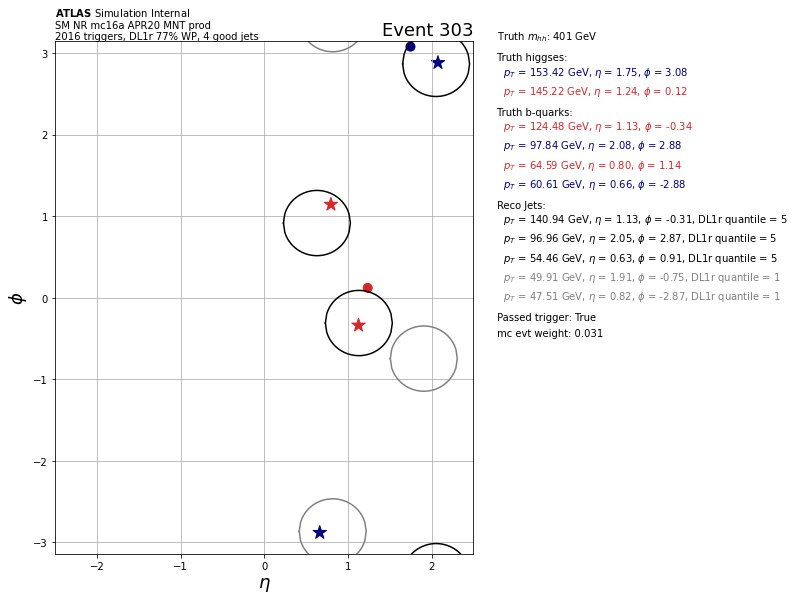

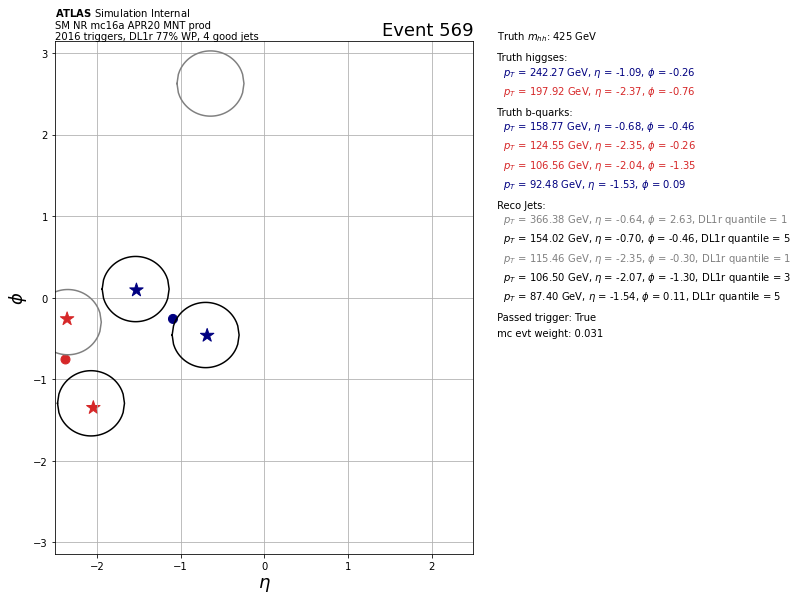

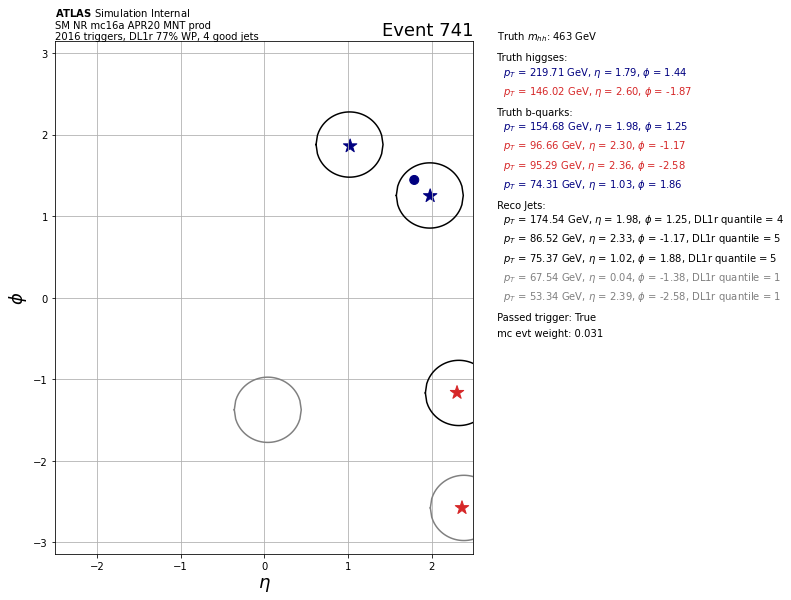

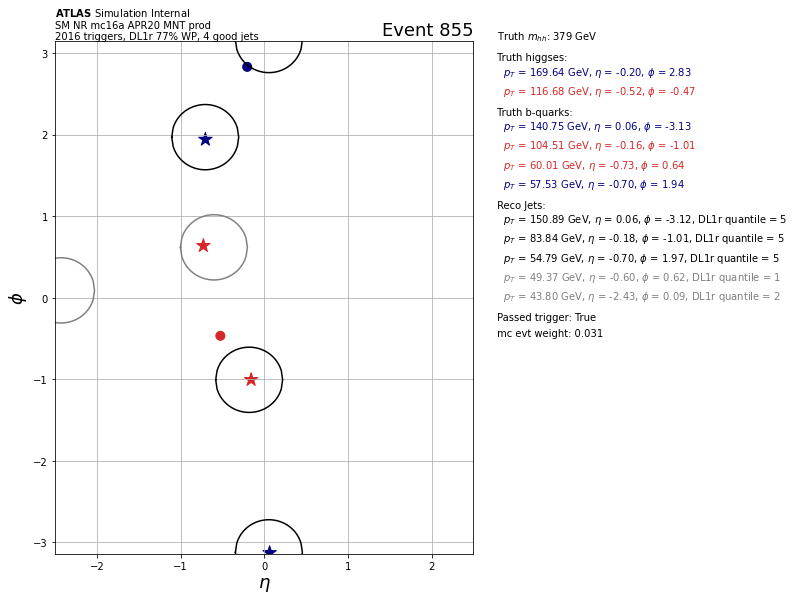

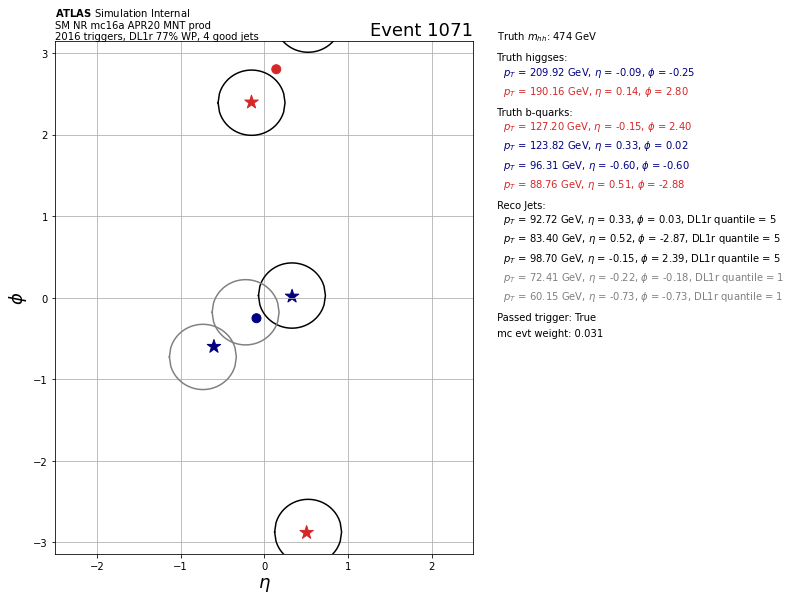

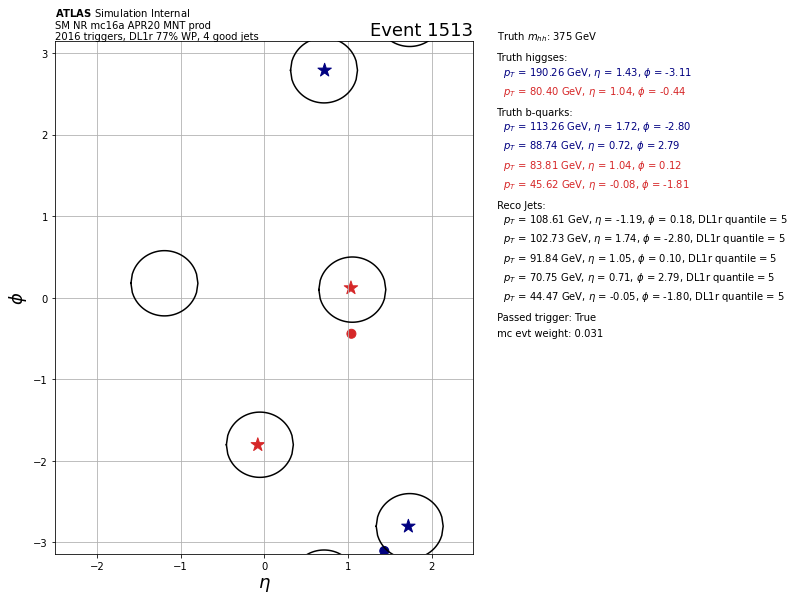

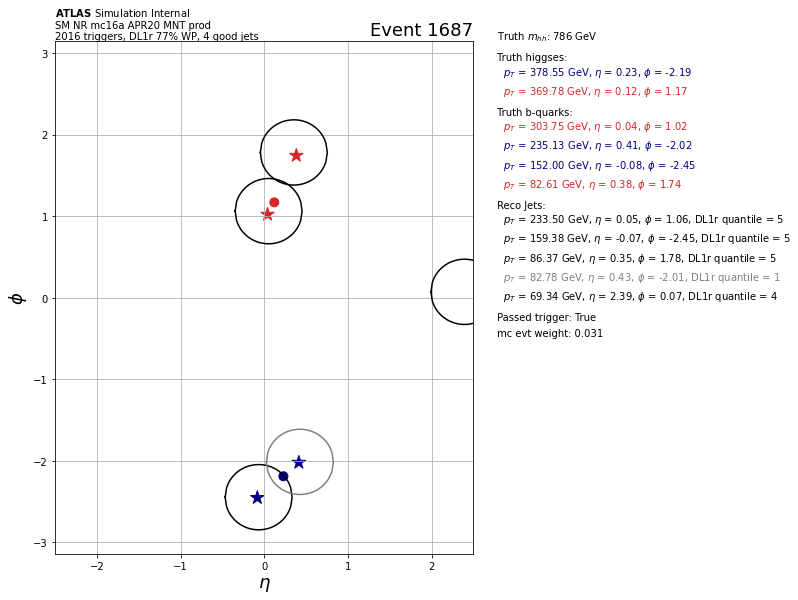

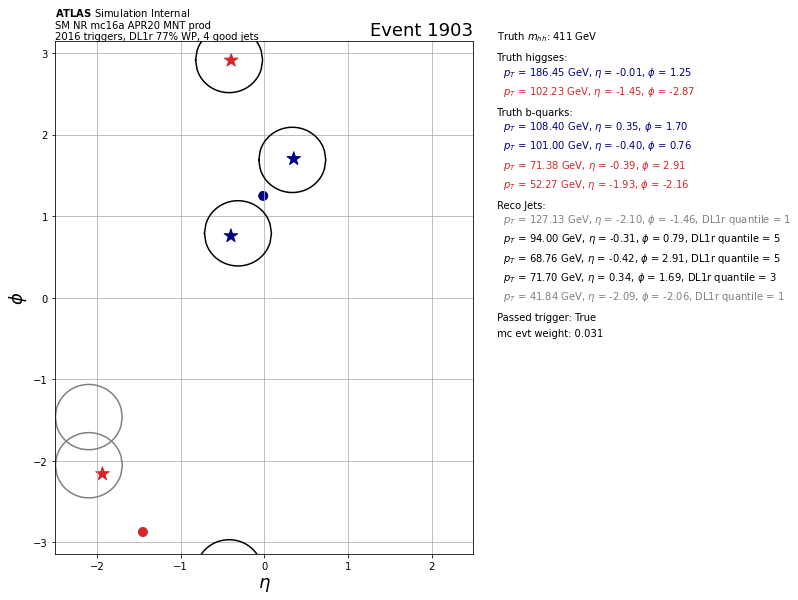

In [32]:
for ievt in differentJets[:10]:

    truthDisplay(ievt,df,triggerKey=True,mode=1,tagger='DL1r',WP=77,quantile=True,
                 text=text,nSelectedJets=5,figDir=f'{figDir}/eventDisplays/pagJetSelRight')

**Question:** What extra info is pairAGraph using? Is it utilizing the recoil at all?

Let's try to find out by plotting 
$$\frac{p_T^{lead \ non-HC}}{p_T^{HH}}$$
as Max asked me to do before when I was looking into the "valid pairings" studies.


In [33]:
baseline_idx#[df['njets']==5]

array([[0., 3., 2., 1.],
       [0., 1., 2., 3.],
       [0., 1., 2., 3.],
       ...,
       [0., 1., 2., 3.],
       [0., 1., 2., 3.],
       [0., 1., 2., 3.]])

In [34]:
i_nonHC = (df.loc[differentJets,[f'j{i}_bidx' for i in range(5)]]==-1).values
pts = df.loc[differentJets,[f'j{i}_pt' for i in range(5)]].values

In [35]:
i_nonHC = (df.loc[differentJets,[f'j{i}_bidx' for i in range(5)]]==-1).values
pts = df.loc[differentJets,[f'j{i}_pt' for i in range(5)]].values

df['recoil_pt'] = 0
df.loc[differentJets,'recoil_pt'] = pts[i_nonHC]

In [36]:
pts[i_nonHC].shape, differentJets.shape

((5376,), (5376,))

In [37]:
differentJets

Int64Index([   303,    569,    741,    855,   1071,   1327,   1399,   1513,
              1687,   1903,
            ...
            684532, 684802, 684894, 685282, 685502, 685734, 686324, 686390,
            686436, 686624],
           dtype='int64', name='entry', length=5376)

In [38]:
figDir

'figures/SMNR_mc16a_PFlow-APR2020-5jets/SM_2b'

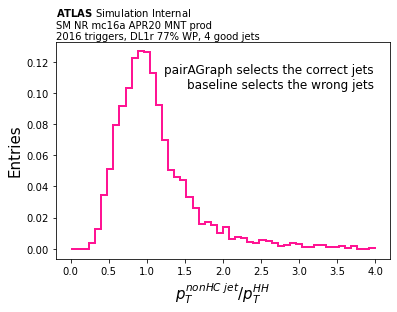

In [39]:
plt.hist(df.loc[differentJets,'recoil_pt'] / df.loc[differentJets,'pt_hh'],50,(0,4),
         color='deeppink',histtype='step',lw=2,weights=df.loc[differentJets,'mc_sf'])
#plt.hist(pts[i_nonHC]/df.loc[differentJets,'pt_hh'],100,(0,5),color='deeppink',histtype='step',lw=2)

plt.xlabel('$p_T^{non HC \ jet} / p_T^{HH}$',fontsize=15)
plt.ylabel('Entries',fontsize=15)

ax = plt.gca()
plt.text(.95,.9,'pairAGraph selects the correct jets\nbaseline selects the wrong jets',
         ha='right',va='top',transform=ax.transAxes,fontsize=12)
plt.text(0,1,text,ha='left',va='bottom',transform=ax.transAxes)

plt.savefig(f'{figDir}/pt_recoil_pt_4j.pdf',bbox_inches='tight')
plt.show()

**Next:** Want to also include the baseline jet selection on this plot!

In [40]:
from uproot_methods.classes.TLorentzVector import TLorentzVectorArray

In [41]:
for c in ['base_nonSelJpt','base_m4j','base_pt4j']:
    df[c] = 0

for i in range(5):
    
    mask = np.sum(baseline_idx==i,axis=1).astype(bool)
    
    df.loc[mask,'base_nonSelJpt'] = df.loc[mask,f'j{i}_pt']
    
    i0,i1,i2,i3 = [ji for ji in range(5) if ji != i]
    
    j0 = TLorentzVectorArray.from_ptetaphie(*df.loc[mask,[f'j{i0}_pt',f'j{i0}_phi',f'j{i0}_eta',f'j{i0}_E']].values.T) 
    j1 = TLorentzVectorArray.from_ptetaphie(*df.loc[mask,[f'j{i1}_pt',f'j{i1}_phi',f'j{i1}_eta',f'j{i1}_E']].values.T) 
    j2 = TLorentzVectorArray.from_ptetaphie(*df.loc[mask,[f'j{i2}_pt',f'j{i2}_phi',f'j{i2}_eta',f'j{i2}_E']].values.T) 
    j3 = TLorentzVectorArray.from_ptetaphie(*df.loc[mask,[f'j{i3}_pt',f'j{i3}_phi',f'j{i3}_eta',f'j{i3}_E']].values.T) 
    
    hh = j0+j1+j2+j3
    
    df.loc[mask,'base_m4j'] = hh.mass
    df.loc[mask,'base_pt4j'] = hh.pt

/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/uproot_methods/classes/TLorentzVector.py:189: RuntimeWarning: invalid value encountered in sqrt
  return self._trymemo("mass", lambda self: self.awkward.numpy.sqrt(self.mag2))


Compare the $p_T$s of the non-selected jet.

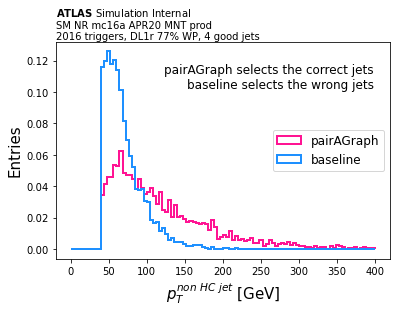

In [42]:
mi = correctJets & (~ baselineCorrect) & (df.correctPair!=-1)

n1,_,_ = plt.hist(df.loc[mi,'recoil_pt'],100,(0,400),label='pairAGraph',
                  color='deeppink',histtype='step',lw=2,weights=df.loc[mi,'mc_sf'])
n2,_,_ = plt.hist(df.loc[mi,'base_nonSelJpt'],100,(0,400),label='baseline',
                  color='dodgerblue',histtype='step',lw=2,weights=df.loc[mi,'mc_sf'])

plt.xlabel('$p_T^{non \ HC \ jet}$ [GeV]',fontsize=15)
plt.ylabel('Entries',fontsize=15)
plt.legend(loc='center right',fontsize=12)

ax = plt.gca()
plt.text(.95,.9,'pairAGraph selects the correct jets\nbaseline selects the wrong jets',
         ha='right',va='top',transform=ax.transAxes,fontsize=12)
plt.text(0,1,text,ha='left',va='bottom',transform=ax.transAxes)

plt.savefig(f'{figDir}/pt_recoil.pdf',bbox_inches='tight')

plt.show()

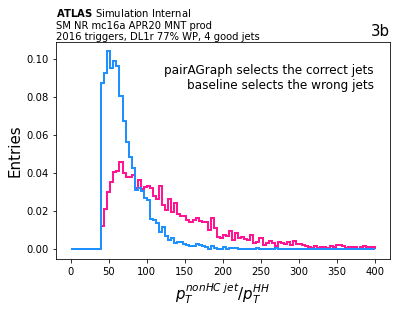

In [43]:
for m, label,tag in zip([df.ntag>=4, (df.ntag==3) & (nLoose>0), (df.ntag==3) & (nLoose==0)],
                        ['4b','3b + 1 loose','3b'],['4b','3b1loose','3b']):

    mask = correctJets & (~ baselineCorrect) & (df.correctPair!=-1) & m
    
    plt.hist(df.loc[mask,'recoil_pt'] ,100,(0,400),color='deeppink',
             histtype='step',lw=2,weights=df.loc[mask,'mc_sf'])
    plt.hist(df.loc[mask,'base_nonSelJpt'],100,(0,400),
             color='dodgerblue',histtype='step',lw=2,weights=df.loc[mask,'mc_sf'])

    plt.xlabel('$p_T^{non HC \ jet} / p_T^{HH}$',fontsize=15)
    plt.ylabel('Entries',fontsize=15)
    plt.title(label,loc='right',fontsize=15)
    
    ax = plt.gca()
    plt.text(.95,.9,'pairAGraph selects the correct jets\nbaseline selects the wrong jets',
             ha='right',va='top',transform=ax.transAxes,fontsize=12)
    plt.text(0,1,text,ha='left',va='bottom',transform=ax.transAxes)

    
    plt.savefig(f'{figDir}/pt_recoil_{tag}.pdf',bbox_inches='tight')
    
    plt.show()

In [44]:
np.sum(n1),np.sum(n2)

(1.3742534837546212, 1.3881428081517477)

**Next:** Let's try to reco the 4-jets from the baseline analysis so I can get $m_{hh}$ and $p_T^{hh}$.

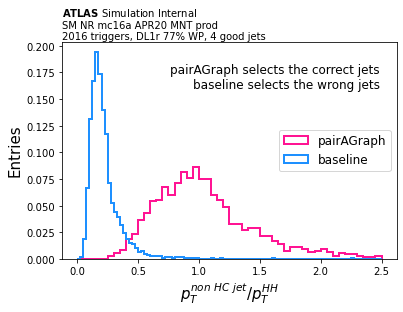

In [45]:
plt.hist(pts[i_nonHC] / df.loc[differentJets,'pt_hh'],50,(0,2.5),
         color='deeppink',label='pairAGraph',histtype='step',
         lw=2,weights=df.loc[differentJets,'mc_sf'])
plt.hist(df.loc[differentJets,'base_nonSelJpt']/df.loc[differentJets,'base_pt4j'],100,(0,2.5),
         color='dodgerblue',label='baseline',histtype='step',
         lw=2,weights=df.loc[differentJets,'mc_sf'])

plt.xlabel('$p_T^{non \ HC \ jet} / p_T^{HH}$',fontsize=15)
plt.ylabel('Entries',fontsize=15)
plt.legend(loc='center right',fontsize=12)

ax = plt.gca()
plt.text(.95,.9,'pairAGraph selects the correct jets\nbaseline selects the wrong jets',
         ha='right',va='top',transform=ax.transAxes,fontsize=12)
plt.text(0,1,text,ha='left',va='bottom',transform=ax.transAxes)

plt.savefig(f'{figDir}/pt_recoil_pt_4j_base.pdf',bbox_inches='tight')

plt.show()

**Next:** Let's break this down by # of b-tags.

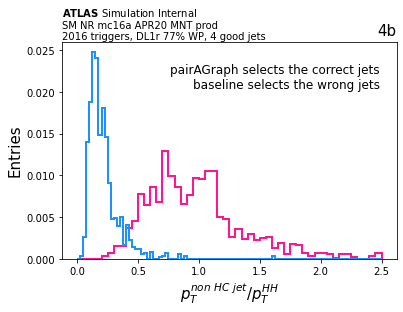

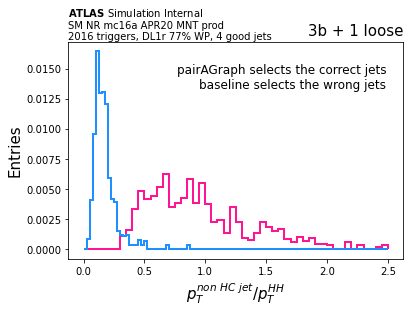

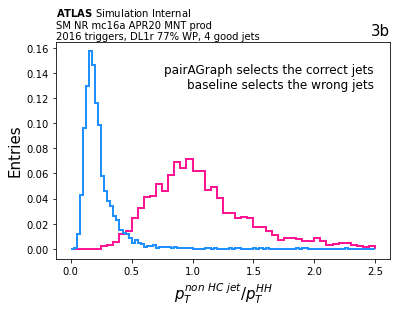

In [46]:
for m, label,tag in zip([df.ntag>=4, (df.ntag==3) & (nLoose>0), (df.ntag==3) & (nLoose==0)],
                        ['4b','3b + 1 loose','3b'],['4b','3b1loose','3b']):

    mask = correctJets & (~ baselineCorrect) & (df.correctPair!=-1) & m
    
    plt.hist(df.loc[mask,'recoil_pt'] / df.loc[mask,'pt_hh'],50,(0,2.5),color='deeppink',
             histtype='step',lw=2,weights=df.loc[mask,'mc_sf'])
    plt.hist(df.loc[mask,'base_nonSelJpt']/df.loc[mask,'base_pt4j'],100,(0,2.5),
             color='dodgerblue',histtype='step',lw=2,weights=df.loc[mask,'mc_sf'])

    plt.xlabel('$p_T^{non \ HC \ jet} / p_T^{HH}$',fontsize=15)
    plt.ylabel('Entries',fontsize=15)
    plt.title(label,loc='right',fontsize=15)
    
    ax = plt.gca()
    plt.text(.95,.9,'pairAGraph selects the correct jets\nbaseline selects the wrong jets',
             ha='right',va='top',transform=ax.transAxes,fontsize=12)
    plt.text(0,1,text,ha='left',va='bottom',transform=ax.transAxes)

    plt.savefig(f'{figDir}/pt_recoil_pt_4j_base_{tag}.pdf',bbox_inches='tight')
    
    plt.show()

**Next:** The studies above were all focusing on plots w/r.t. the pairAGraph preselection - but I think it's *also* important to compare how 4b compares to the resonant analysis jet selection.

In [1]:
filename = '/gpfs/slac/atlas/fs1/d/nhartman/public/hh4b/'
filename+= 'kappa_lambda/user.valentem.HH4B.600043.HH_NLO.'
filename+= 'MC16a-2015-2016.AB21.2.91-APR20-1.full_MiniNTuple.root/'
filename+= 'user.valentem.21562918._000001.MiniNTuple.root'

In [6]:
df_base = process4bs(filename, year=2016, pT_min=40)


Opening /gpfs/slac/atlas/fs1/d/nhartman/public/hh4b/kappa_lambda/user.valentem.HH4B.600043.HH_NLO.MC16a-2015-2016.AB21.2.91-APR20-1.full_MiniNTuple.root/user.valentem.21562918._000001.MiniNTuple.root
Loading in the event df
Running on mc
Loading in the jet array
  Jet sfs for evts with 4 selected jets out of 4 resolved jets
  Jet sfs for evts with 4 selected jets out of 5 resolved jets
  Jet sfs for evts with 5 selected jets out of 5 resolved jets
  Jet sfs for evts with 4 selected jets out of 6 resolved jets
  Jet sfs for evts with 5 selected jets out of 6 resolved jets
  Jet sfs for evts with 6 selected jets out of 6 resolved jets
  Jet sfs for evts with 4 selected jets out of 7 resolved jets
  Jet sfs for evts with 5 selected jets out of 7 resolved jets
  Jet sfs for evts with 6 selected jets out of 7 resolved jets
  Jet sfs for evts with 7 selected jets out of 7 resolved jets
  Jet sfs for evts with 4 selected jets out of 8 resolved jets
  Jet sfs for evts with 5 selected jets out

In [7]:
df_base.head()

eventNumber  nresolvedJets  weight_pileup  resolved_nBTags  \
entry                                                               
6           285652              8       1.081466                4   
8           286268              8       0.874719                4   
20          285989              5       1.114303                5   
32          286524              6       0.925304                4   
35          286184              6       0.575480                4   

       resolved_nValidPairings  resolved_isSR  resolved_isCR  resolved_isSB  \
entry                                                                         
6                            3          False          False          False   
8                            1           True          False          False   
20                           0          False          False          False   
32                           2          False           True          False   
35                           2          False          False          False   

       resolved_nGoodJets  mcEventWeight  ...  j1_drMatch  j2_drMatch  \
entry                                     ...                           
6                       0       0.031172  ...    0.108736    0.053379   
8                       1       0.031172  ...    0.006739    0.131960   
20                      0      -0.031172  ...    0.017168    0.006077   
32                      0       0.031172  ...    0.015350    0.074250   
35                      0       0.031172  ...    0.114059    0.113417   

       j3_drMatch  correctPair  sameParent  unique  dRmatch  goodJets  ntag  \
entry                                                                         
6        0.107849            2       False    True     True      True     4   
8        0.074484            2       False    True     True      True     4   
20       0.058192           -1       False   False    False     False     4   
32       0.033710            2       False    True     True      True     4   
35       0.029218            1       False    True     True      True     4   

       GNNJets  
entry           
6            4  
8            4  
20           4  
32           4  
35           4  

[5 rows x 95 columns]

**Next:** Let's reproduce the pairAGraph 4b metrics!

**Step 1:** Jet selection accuracy


In [31]:
df_base.loc[df_base.ntag != df_base.ntag_all,'ntag_all'].min()

5.0

^ Sanity check - the only difference b/w the `ntag_all` and `ntag` baseline is when the event had $\geq$ 5 $b$-tagged $p_T$ > 40 GeV jets.

*How often does this happen?*

In [37]:
print('How often do we have 5b events in the mc16a signal?')

mask = np.ones_like(df_base.index).astype(bool)

for m, text in zip([np.ones_like(df_base.index).astype(bool),df_base.trigger],
                   ['4b','2016 triggers']):

    mask = mask & m
    
    num = np.sum(df_base.loc[(df_base.ntag != df_base.ntag_all)& mask,'mc_sf'])
    den = np.sum(df_base.loc[mask,'mc_sf'])
    eff = 100 *  num / den
    
    print(f'{text}: {eff:.2f}%')
    

How often do we have 5b events in the mc16a signal?
4b: 2.52%
2016 triggers: 2.77%


Very rarely - less than 3% of the time.

*So next, I was sort of wanting to see how often the baseline got the correct jets!*

I can't really do the given solvable problem here, since that would be 100% (by definition), so I'll do relative to the *whole* signal.

In [59]:
print('How often do we select the correct jets? (w/r.t. mc_sf)')
mask = np.ones_like(df_base.index).astype(bool)

for m, text in zip([np.ones_like(df_base.index).astype(bool),df_base.trigger],
                   ['4b','2016 triggers']):

    mask = mask & m
    
    num = np.sum(df_base.loc[df_base.goodJets & mask,'mc_sf'])
    den = np.sum(df_base.loc[mask,'mc_sf'])
    eff = 100 *  num / den
    
    print(f'{text}: {eff:.2f}% (num = {num:.2f}, den={den:.2f})')
    

How often do we select the correct jets? (w/r.t. mc_sf)
4b: 78.95% (num = 1858.70, den=2354.19)
2016 triggers: 79.34% (num = 1653.11, den=2083.58)


This is approximately the same as the last time I did this check, and what's changed now is we've changed the tagger and the WP.

Let's also get w/o the jet SFs included, since this is something that is slightly different depending on how I do the jet selection.

In [57]:
print('How often do we select the correct jets? (w/r.t. mcEventWeight * weight_pileup)')
mask = np.ones_like(df_base.index).astype(bool)

for m, text in zip([np.ones_like(df_base.index).astype(bool),df_base.trigger],
                   ['4b','2016 triggers']):

    mask = mask & m
    
    num = np.sum(df_base.loc[df_base.goodJets & mask,'mcEventWeight'] * df_base.loc[df_base.goodJets & mask,'weight_pileup'])
    den = np.sum(df_base.loc[mask,'mcEventWeight'] * df_base.loc[mask,'weight_pileup'])
    eff = 100 *  num / den
    
    print(f'{text}: {eff:.2f}% (num = {num:.2f}, den={den:.2f})')
    

How often do we select the correct jets? (w/r.t. mcEventWeight * weight_pileup)
4b: 78.90% (num = 1735.49, den=2199.64)
2016 triggers: 79.28% (num = 1545.15, den=1949.05)


In [58]:
print('How often do we select the correct jets? (w/r.t. mcEventWeight)')
mask = np.ones_like(df_base.index).astype(bool)

for m, text in zip([np.ones_like(df_base.index).astype(bool),df_base.trigger],
                   ['4b','2016 triggers']):

    mask = mask & m
    
    num = np.sum(df_base.loc[df_base.goodJets & mask,'mcEventWeight'])
    den = np.sum(df_base.loc[mask,'mcEventWeight'])
    eff = 100 *  num / den
    
    print(f'{text}: {eff:.2f}% (num = {num:.2f}, den={den:.2f})')
    

How often do we select the correct jets? (w/r.t. mcEventWeight)
4b: 78.87% (num = 1735.48, den=2200.55)
2016 triggers: 79.24% (num = 1545.12, den=1949.81)


In [62]:
print('How often do we select the correct jets? (unwieghted (debugging only))')
mask = np.ones_like(df_base.index).astype(bool)

for m, text in zip([np.ones_like(df_base.index).astype(bool),df_base.trigger],
                   ['4b','2016 triggers']):

    mask = mask & m
    
    num = np.sum(df_base.goodJets & mask)
    den = np.sum(mask)
    eff = 100 *  num / den
    
    print(f'{text}: {eff:.2f}% (num = {num:.0f}, den={den:.0f})')
    

How often do we select the correct jets? (unwieghted (debugging only))
4b: 79.28% (num = 64736, den=81651)
2016 triggers: 79.70% (num = 57956, den=72715)


In [65]:
df_base[['dRmatch','unique','goodJets','correctPair']]

dRmatch  unique  goodJets  correctPair
entry                                         
6          True    True      True            2
8          True    True      True            2
20        False   False     False           -1
32         True    True      True            2
35         True    True      True            1
...         ...     ...       ...          ...
686642    False    True     False           -1
686657     True    True      True            2
686659     True    True      True            1
686695     True    True      True            2
686705     True    True      True            2

[81651 rows x 4 columns]

In [66]:
np.min(df_base.loc[df_base.goodJets,'correctPair'])

0

In [67]:
np.sum(df_base.goodJets),np.sum(df_base.correctPair!=-1)

(64736, 64736)

In [71]:
evtNum_base = df_base.loc[df_base.goodJets & (df_base.trigger),'eventNumber'].values
evtNum_base

array([ 286268,  286524,  286184, ..., 1225770, 1225400, 1225504])

In [72]:
len(evtNum_base)

57956

### Midplay summary

Ok, so it doesn't make sense why the baseline considering all the jets can have a smaller numerator than the baseline considering j the 5 leading jets (right?).

**Plan:** Maybe debug by looking at the `eventNumber` b/w these 2 dfs?

In [63]:
df.columns

Index(['eventNumber', 'nresolvedJets', 'resolved_nBTags', 'mcEventWeight',
       'weight_pileup', 'rand_run_nr', 'j0_pt', 'j0_eta', 'j0_phi', 'j0_E',
       ...
       'cosThetaStar', 'cosTheta1', 'cosTheta12', 'cosTheta2', 'Phi', 'Phi1',
       'HT', 'event_number', 'dPhi_h1', 'dPhi_h2'],
      dtype='object', length=162)

Yep, yep, found the bug, corrected above... moving on!!

**Step 2:** Jet selection as a function of $m_{hh}$

Since there's an ambiguity in ...

In [ ]:
#fig, axes = plt.subplots(1,3,figsize=(13,4))

for mask, ax,label in zip([df.ntag>=4, (df.ntag==3) & (nLoose>0), (df.ntag==3) & (nLoose==0)],
                           axes, ['4b','3b + 1 loose','3b']):
    
    #mask =  m & (df.correctPair!=-1)
    den,_ = np.histogram(df.loc[mask,'truth_mhh'],mhh_edg,weights=df.loc[mask,'mc_sf'])

    for mi, l,color in zip([correctJets,baselineCorrect],['pairAGraph','baseline'],['deeppink','dodgerblue']):
        
        num,_  = np.histogram(df.loc[mask & mi & df.goodJets,'truth_mhh'],mhh_edg,
                              weights=df.loc[mask & mi & df.goodJets,'mc_sf'])
        
        sqd,_  = np.histogram(df.loc[mask & mi & df.goodJets,'truth_mhh'],mhh_edg,
                              weights=df.loc[mask & mi & df.goodJets,'mc_sf']**2)
        
        ax.plot(xx, num/den, color=color,label=l, marker='.',linewidth=0.5)
        
    ax.set_xlabel('truth $m_{hh}$ [GeV]',fontsize=15)
    if label == '4b':
        ax.set_ylabel('Jet selection accuracy',fontsize=15)
        ax.text(0,1,text,ha='left',va='bottom',transform=ax.transAxes)  
    elif label=='3b':
        ax.set_title('5 leading $p_T > 40$ GeV, $|\eta|<2.5$ jets',
                     loc='right',fontsize=15)
    
    ax.text(0.05,0.95,label,ha='left',va='top',fontsize=15,transform=ax.transAxes)
    ax.legend(loc='lower right',fontsize=12)
        
    plt.savefig(f'{figDir}/jetSelAcc_truth_mhh_allJets.pdf',bbox_inches='tight')

## Next: Let's look at the pairing accuracy vs $m_{hh}$

**Recall:** From my pairing studies before, it seemed like the accuracy was *pretty* stable w/r.t. 4b, but I was having some more *issues* w/r.t. 
